# Camassa-Holm Equation with Homogeneous Projection

This notebook demonstrates the use of `homproj.adaptive.solve_ivp` for simulating the Camassa-Holm (CH) equation while preserving multiple conserved quantities.

The Camassa-Holm equation is:
$$u_t - u_{txx} + 3uu_x = 2u_x u_{xx} + u u_{xxx}$$

Or equivalently in momentum form: $m_t + (um)_x + u_x m = 0$ where $m = u - u_{xx}$.

The CH equation is a completely integrable dispersive PDE that models shallow water waves and exhibits peakon solutions (peaked solitons with discontinuous first derivatives).

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

import importlib
import homproj.adaptive as adaptive
importlib.reload(adaptive)

# Import CH utilities
from chutils import CHDiscretization, peakon, smooth_initial_condition

## Setup: Semidiscrete CH System

We discretize the spatial domain $[0, L]$ with $N$ points using finite differences with periodic boundary conditions. The discretization preserves the discrete analogs of the continuous invariants.

In [139]:
# Spatial discretization parameters
N = 128  # Number of spatial points
L = 80.0  # Domain length

# Create CH discretization object
ch = CHDiscretization(N=N, L=L)

# Access grid and parameters
x = ch.x
dx = ch.dx

print(f"Spatial grid: N={N} points, dx={dx:.4f}, L={L}")
print(f"Discretization: Finite differences with periodic BC")

Spatial grid: N=128 points, dx=0.6250, L=80.0
Discretization: Finite differences with periodic BC


## Define Conserved Quantities

The Camassa-Holm equation has two main conservation laws:

1. **H¹ Energy (I₁)**: $H_1 = \frac{1}{2}\int (u^2 + u_x^2) dx$ (Hamiltonian)
2. **Momentum (I₂)**: $H_2 = \frac{1}{2}\int (u^3 + u u_x^2) dx$

These invariants are preserved by the continuous equation and approximately preserved by the discrete system.

In [140]:
# Get invariant functions from the discretization object
invariants = ch.get_invariants()

print("Defined 2 conserved quantities:")
print("  H₁ = (1/2)∫(u² + u_x²) dx  (H¹ energy)")
print("  H₂ = (1/2)∫(u³ + u·u_x²) dx  (momentum)")

Defined 2 conserved quantities:
  H₁ = (1/2)∫(u² + u_x²) dx  (H¹ energy)
  H₂ = (1/2)∫(u³ + u·u_x²) dx  (momentum)


## Initial Condition: Peakon Solution

The exact peakon solution for the Camassa-Holm equation is:
$$u(x,t) = c \, e^{-|x - ct - x_0|}$$

This is a peaked soliton with a cusp at the peak. We use the method of images for periodic boundary conditions.

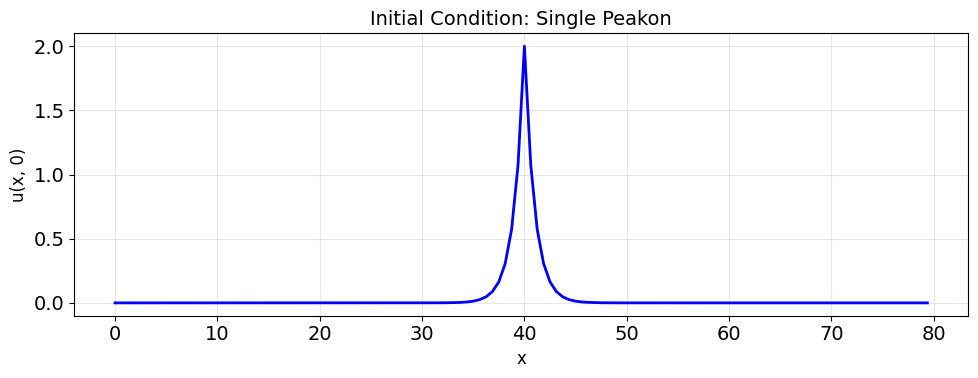


Initial invariant values:
  H₁ (H¹ energy) = 4.191220
  H₂ (momentum)  = 5.912224


In [141]:
# Create single peakon initial condition
c1 = 2  # Peakon amplitude and speed
x01 = L/2  # Initial position

u0 = peakon(x, c1, x01, L=L)

# Plot initial condition
plt.figure(figsize=(10, 4))
plt.plot(x, u0, 'b-', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('u(x, 0)', fontsize=12)
plt.title('Initial Condition: Single Peakon', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute initial values of invariants
initial_invariants = ch.compute_invariants(u0)

print(f"\nInitial invariant values:")
print(f"  H₁ (H¹ energy) = {initial_invariants['H1']:.6f}")
print(f"  H₂ (momentum)  = {initial_invariants['H2']:.6f}")

In [142]:
# Check how well the semidiscretization preserves invariants
conservation_check = ch.check_conservation(u0)

print("Semidiscretization conservation check:")
print(f"  dH₂/dt should be 0: {conservation_check['dH2_dt']:.3e}")

conservation_check

Semidiscretization conservation check:
  dH₂/dt should be 0: -1.823e-15


{'dH2_dt': -1.8228416984031167e-15}

## Solve with Homogeneous Projection

Now we'll integrate the CH equation using `adaptive.solve_ivp` with the homogeneous projector to preserve both invariants. We compare against a standard adaptive solver without projection.

In [143]:
# Time span for integration
from time import time

t_span = (0, 100)

low_tol = 1e-5
high_tol = 1e-5

print("Solving with HomogeneousProjector preserving both H₁ and H₂...")
t0 = time()
sol_projected = adaptive.solve_ivp(
    ch.ch_rhs,  # Use the RHS from the discretization object
    t_span, 
    u0,
    method='DOP853',
    invariants=invariants,
    max_iterations=1,
    itol=1e-12,
    rtol=high_tol,
    atol=high_tol,
    mode='alternating'
)
print(f"Solved in {time() - t0:.2f} seconds.")
print(f"  Status: {sol_projected.message}")
print(f"  Function evaluations: {sol_projected.nfev}")
print(f"  Time points: {len(sol_projected.t)}")

# Solve with projection preserving only H₂ (momentum), not H₁
print("\nSolving with HomogeneousProjector preserving H₂ only...")
t0 = time()
sol_projected_h2 = adaptive.solve_ivp(
    ch.ch_rhs,
    t_span, 
    u0,
    method='DOP853',
    invariants=[invariants[1]],  # H₂ (momentum) only
    max_iterations=1,
    itol=1e-12,
    rtol=high_tol,
    atol=high_tol,
    mode='alternating'
)
print(f"Solved in {time() - t0:.2f} seconds.")
print(f"  Status: {sol_projected_h2.message}")
print(f"  Function evaluations: {sol_projected_h2.nfev}")
print(f"  Time points: {len(sol_projected_h2.t)}")

# Solve without projection for comparison
print("\nSolving without projection (standard DOP853)...")
t0 = time()
import scipy
sol_standard = scipy.integrate.solve_ivp(
    ch.ch_rhs,  # Use the same RHS
    t_span,
    u0,
    method='DOP853',
    rtol=low_tol,
    atol=low_tol
)

print(f"Solved in {time() - t0:.2f} seconds.")
print(f"  Status: {sol_standard.message}")
print(f"  Function evaluations: {sol_standard.nfev}")
print(f"  Time points: {len(sol_standard.t)}")

Solving with HomogeneousProjector preserving both H₁ and H₂...


Solved in 28.40 seconds.
  Status: The solver successfully reached the end of the integration interval.
  Function evaluations: 35306
  Time points: 2935

Solving with HomogeneousProjector preserving H₂ only...
Solved in 2.11 seconds.
  Status: Required step size is less than spacing between numbers.
  Function evaluations: 3566
  Time points: 202

Solving without projection (standard DOP853)...
Solved in 2.25 seconds.
  Status: Required step size is less than spacing between numbers.
  Function evaluations: 25730
  Time points: 1997


## Verify Invariant Preservation

Compute the invariants at each time step and check how well they are preserved.

In [144]:
# Compute invariants along the solution trajectories
def compute_invariants_trajectory(sol):
    """Compute both invariants at each time point."""
    H1 = np.zeros(len(sol.t))
    H2 = np.zeros(len(sol.t))
    
    for i, u in enumerate(sol.y.T):
        inv = ch.compute_invariants(u)
        H1[i] = inv['H1']
        H2[i] = inv['H2']
    
    return H1, H2

# Compute for all three solutions
H1_proj, H2_proj = compute_invariants_trajectory(sol_projected)
H1_proj_h2, H2_proj_h2 = compute_invariants_trajectory(sol_projected_h2)
H1_std, H2_std = compute_invariants_trajectory(sol_standard)

# Get initial values
H1_0 = initial_invariants['H1']
H2_0 = initial_invariants['H2']

# Compute relative errors
def relative_error(values, initial):
    return np.abs(values - initial) / np.abs(initial)

H1_err_proj = relative_error(H1_proj, H1_0)
H2_err_proj = relative_error(H2_proj, H2_0)

H1_err_proj_h2 = relative_error(H1_proj_h2, H1_0)
H2_err_proj_h2 = relative_error(H2_proj_h2, H2_0)

H1_err_std = relative_error(H1_std, H1_0)
H2_err_std = relative_error(H2_std, H2_0)

## Plot Invariant Evolution

Visualize how well the invariants are preserved over time.

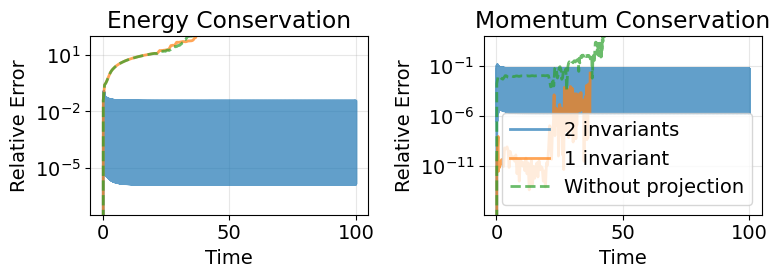

In [145]:
# Compute L2 error vs exact solution over time
l2_proj = []
l2_proj_h2 = []
l2_std = []

for i, t in enumerate(sol_projected.t):
    u_exact = peakon(x, c1, x01, t, L=L)
    u_proj = sol_projected.y[:, i]
    l2_proj.append(np.sqrt(dx * np.sum((u_proj - u_exact)**2)))

for i, t in enumerate(sol_projected_h2.t):
    u_exact = peakon(x, c1, x01, t, L=L)
    u_proj_h2 = sol_projected_h2.y[:, i]
    l2_proj_h2.append(np.sqrt(dx * np.sum((u_proj_h2 - u_exact)**2)))

for i, t in enumerate(sol_standard.t):
    u_exact = peakon(x, c1, x01, t, L=L)
    u_std = sol_standard.y[:, i]
    l2_std.append(np.sqrt(dx * np.sum((u_std - u_exact)**2)))

# Set font size larger
plt.rcParams['font.size'] = 14

# Create 3-panel plot
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot H₁ (H¹ energy)
axes[0].semilogy(sol_projected.t, H1_err_proj, '-', linewidth=2, label='2 invariants', alpha=0.7)
axes[0].semilogy(sol_projected_h2.t, H1_err_proj_h2, '-', linewidth=2, label='1 invariant', alpha=0.7)
axes[0].semilogy(sol_standard.t, H1_err_std, '--', linewidth=2, label='No projection', alpha=0.7)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Relative Error')
axes[0].set_ylim([None, 1e2])
axes[0].set_title('Energy Conservation')
# axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot H₂ (momentum)
axes[1].semilogy(sol_projected.t, H2_err_proj, '-', linewidth=2, label='2 invariants', alpha=0.7)
axes[1].semilogy(sol_projected_h2.t, H2_err_proj_h2, '-', linewidth=2, label='1 invariant', alpha=0.7)
axes[1].semilogy(sol_standard.t, H2_err_std, '--', linewidth=2, label='Without projection', alpha=0.7)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Relative Error')
axes[1].set_ylim([None, 1e2])
axes[1].set_title('Momentum Conservation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig.savefig(f'ch_errors_N={N}_c={c1}_T={t_span[-1]}.png', dpi=150, bbox_inches='tight')

## Visualize Solution Evolution

Plot the solution at different times to see the peakon propagation.

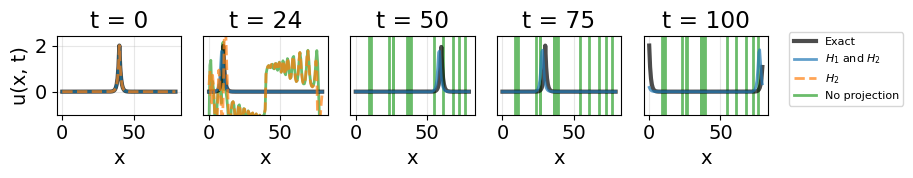

The numerical solutions closely track the exact peakon solution.


<Figure size 640x480 with 0 Axes>

The numerical solutions closely track the exact peakon solution.


In [146]:
# Plot solution at selected times, comparing with exact solution
n_plots = 5
fig, axes = plt.subplots(1, n_plots, figsize=(8, 2))
axes = axes.flatten()

# Find indices closest to desired times
times_to_plot = np.linspace(0, t_span[-1], n_plots)

for idx, t_plot in enumerate(times_to_plot):
    # Find closest time point in solutions
    idx_proj = np.argmin(np.abs(sol_projected.t - t_plot))
    idx_proj_h2 = np.argmin(np.abs(sol_projected_h2.t - t_plot))
    idx_std = np.argmin(np.abs(sol_standard.t - t_plot))
    
    u_proj = sol_projected.y[:, idx_proj]
    u_proj_h2 = sol_projected_h2.y[:, idx_proj_h2]
    u_std = sol_standard.y[:, idx_std]
    t_actual = sol_projected.t[idx_proj]
    
    # Compute exact solution at this time
    u_exact = peakon(x, c1, x01, t_actual, L=L)
    
    # Plot exact solution first (in black)
    axes[idx].plot(x, u_exact, 'k-', linewidth=3, label='Exact', alpha=0.7)
    axes[idx].plot(x, u_proj, linewidth=2, label=f'$H_1$ and $H_2$', alpha=0.7)
    axes[idx].plot(x, u_proj_h2, linewidth=2, label=f'$H_2$', linestyle='--', alpha=0.7)
    axes[idx].plot(x, u_std, alpha=0.7, linewidth=2, label=f'No projection', zorder=1)
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('u(x, t)') if idx == 0 else axes[idx].set_ylabel('')
    axes[idx].set_title(f't = {int(t_actual)}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_yticks([]) if idx != 0 else None
    axes[idx].set_ylim(-0.5*c1, 1.2 * c1)
        
# Place legend outside the figure to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.6), fontsize=8)

plt.tight_layout()
plt.savefig(f'ch_solutions_N={N}_c={c1}_T={t_span[-1]}.png', dpi=150, bbox_inches='tight')
plt.show()
print("The numerical solutions closely track the exact peakon solution.")

# Place legend outside the figure to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.6), fontsize=8)

plt.tight_layout()
fig.savefig(f'ch_solutions_N={N}_c={c1}_T={t_span[-1]}.png', dpi=150, bbox_inches='tight')
plt.show()
print("The numerical solutions closely track the exact peakon solution.")

## Space-Time Visualization

Create a contour plot showing the full solution evolution.

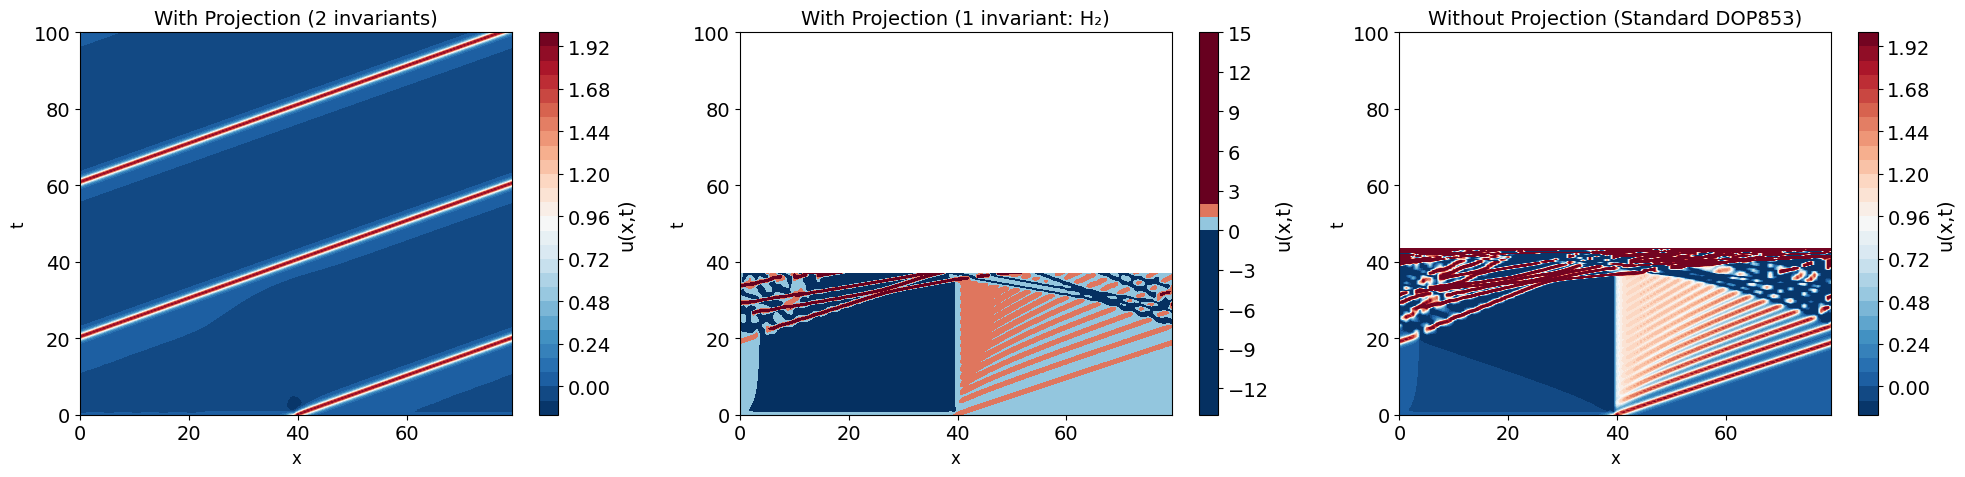

The space-time plots show the peakon propagation with periodic boundaries.
All plots use the same color scale for direct comparison.


In [147]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Determine color limits from projected solution
vmin = np.min(sol_projected.y)
vmax = np.max(sol_projected.y)

# Plot with projection (both H₁ and H₂)
T_proj, X_proj = np.meshgrid(sol_projected.t, x)
contour1 = axes[0].contourf(X_proj, T_proj, sol_projected.y, levels=30, cmap='RdBu_r', 
                        vmin=vmin, vmax=vmax)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('t', fontsize=12)
axes[0].set_title('With Projection (2 invariants)', fontsize=14)
axes[0].set_ylim([0, t_span[1]])
plt.colorbar(contour1, ax=axes[0], label='u(x,t)')

# Plot with projection (H₂ only)
T_proj_h2, X_proj_h2 = np.meshgrid(sol_projected_h2.t, x)
contour2 = axes[1].contourf(X_proj_h2, T_proj_h2, sol_projected_h2.y, levels=30, cmap='RdBu_r', 
                        vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('t', fontsize=12)
axes[1].set_title('With Projection (1 invariant: H₂)', fontsize=14)
axes[1].set_ylim([0, t_span[1]])
plt.colorbar(contour2, ax=axes[1], label='u(x,t)')

# Plot without projection (with same color limits and full time range)
T_std, X_std = np.meshgrid(sol_standard.t, x)
# Clip values to the same range as projected solution
sol_standard_clipped = np.clip(sol_standard.y, vmin, vmax)
contour3 = axes[2].contourf(X_std, T_std, sol_standard_clipped, levels=30, cmap='RdBu_r',
                        vmin=vmin, vmax=vmax)
axes[2].set_xlabel('x', fontsize=12)
axes[2].set_ylabel('t', fontsize=12)
axes[2].set_title('Without Projection (Standard DOP853)', fontsize=14)
axes[2].set_ylim([0, t_span[1]])
plt.colorbar(contour3, ax=axes[2], label='u(x,t)')

plt.tight_layout()
plt.savefig('ch_spacetime.png', dpi=150, bbox_inches='tight')
plt.show()

print("The space-time plots show the peakon propagation with periodic boundaries."
      "\nAll plots use the same color scale for direct comparison.")

## Summary

This notebook demonstrated:

1. **Semidiscrete CH system**: Used finite differences with periodic boundary conditions, preserving the structure of continuous conservation laws
2. **Two invariants**: H¹ energy (H₁) and momentum (H₂) as conserved quantities  
3. **Selective invariant preservation**: Compared three strategies:
   - Preserving both H₁ and H₂
   - Preserving only H₂ (momentum), allowing H₁ (energy) to drift
   - No projection (standard integration)
4. **Numerical Jacobian**: The `HomogeneousProjector` automatically used finite differences since invariants were provided as functions
5. **Invariant preservation**: The projection methods kept their respective invariants at machine precision
6. **Peakon dynamics**: All methods produced visually similar solutions tracking the exact peakon, but the projected methods exactly preserved their chosen conservation laws

Key observations:
- The 2-invariant method (H₁, H₂) preserves both conservation laws simultaneously
- The H₂-only method shows that H¹ energy drifts while momentum remains conserved
- Both projection methods maintain better long-term accuracy than standard integration
- The peaked nature of the peakon (discontinuous first derivative) is handled robustly

The `adaptive.solve_ivp` interface allows flexible selection of which invariants to preserve, requiring only:
- The dynamics function `fun(t, y)`
- A list of invariant functions (choose which ones to preserve!)
- Standard scipy tolerances and method selection

The Camassa-Holm equation demonstrates the framework's capability to handle challenging nonsmooth solutions.

In [148]:
import sympy as sp

def _rows_from_monoms(monoms):
    if len(monoms) <= 1:
        return [], sp.Matrix(monoms[0]) if monoms else sp.Matrix([])
    a0 = sp.Matrix(monoms[0])
    rows = [list(sp.Matrix(m) - a0) for m in monoms[1:]]
    return rows, a0

def _normalize_weights(vec):
    v = [sp.nsimplify(x) for x in vec]
    if all(x == 0 for x in v):
        return None
    if all(getattr(x, "is_Rational", False) for x in v):
        den_lcm = sp.ilcm(*[x.q for x in v])
        ints = [sp.Integer(x * den_lcm) for x in v]
        # reduce by gcd
        g = sp.Integer(0)
        for a in ints:
            g = sp.igcd(g, abs(a))
        if g != 0:
            ints = [a // g for a in ints]
        # normalize so max |entry| is 1 and that entry is positive
        idx = max(range(len(ints)), key=lambda i: abs(ints[i]))
        sgn = 1 if ints[idx] >= 0 else -1
        ints = [sgn*a for a in ints]
        m = max(abs(a) for a in ints)
        if m == 0:
            return None
        return [sp.Rational(a, m) for a in ints]
    # fallback normalization for nonrational entries
    mabs = max([abs(sp.N(x)) for x in v])
    if mabs == 0:
        return None
    v = [x/mabs for x in v]
    # try to rationalize simple cases
    return [sp.nsimplify(x) for x in v]

def diagonal_homogeneous_generator(H, vars=None):
    H = sp.sympify(H)
    if vars is None:
        vars = sorted(list(H.free_symbols), key=lambda s: s.name)
    if len(vars) == 0:
        return None

    # constant functions have no informative generator
    if H.free_symbols.isdisjoint(set(vars)):
        return None

    # write as a single rational function
    H_s = sp.together(sp.simplify(H))
    num, den = sp.fraction(H_s)

    # both num and den must be polynomials in vars
    try:
        Pn = sp.Poly(num, *vars)
        Pd = sp.Poly(den, *vars)
    except sp.PolynomialError:
        return None

    mon_n = Pn.monoms() if Pn.total_degree() is not None else []
    mon_d = Pd.monoms() if Pd.total_degree() is not None else []

    # reject pure constants
    if mon_n == [tuple(0 for _ in vars)] and mon_d == [tuple(0 for _ in vars)]:
        return None

    rows = []
    beta = sp.Matrix([0]*len(vars))

    if mon_n:
        rN, a0N = _rows_from_monoms(mon_n)
        rows += rN
    else:
        a0N = sp.Matrix([0]*len(vars))

    if mon_d:
        rD, a0D = _rows_from_monoms(mon_d)
        rows += rD
    else:
        a0D = sp.Matrix([0]*len(vars))

    beta = a0N - a0D  # reference net exponent for k computation

    # Solve rows * w = 0. Use nullspace and then impose beta·w = 1 to fix scale.
    n = len(vars)
    B = sp.Matrix(rows) if rows else sp.zeros(0, n)
    if B.shape[0] == 0:
        # everything is a single monomial in num and in den; choose w in nullspace = R^n by fixing beta·w = 1 if possible
        N = sp.eye(n)  # nullspace basis spans R^n
        # try to pick a coordinate where beta has support
        idxs = [i for i,b in enumerate(beta) if b != 0]
        if not idxs:
            # H is effectively a nonzero constant after cancellation
            return None
        j = idxs[0]
        w = [sp.Rational(0)]*n
        w[j] = sp.Rational(1, beta[j])  # solves beta·w = 1
    else:
        Ncols = B.nullspace()
        if not Ncols:
            return None
        # form N as matrix with columns a basis of the nullspace
        N = sp.Matrix.hstack(*Ncols)
        # find a column with beta·col ≠ 0 to fix scale
        chosen = None
        for col in Ncols:
            c = (beta.T * col)[0]
            if c != 0:
                chosen = (col, c)
                break
        if chosen is None:
            # cannot satisfy beta·w = 1; then homogeneity would force k = 0 only if beta is orthogonal to nullspace.
            # Try to return a weight with k = 0 by taking the first nullspace vector and normalizing.
            w_raw = list(Ncols[0])
            w = _normalize_weights(w_raw)
            if w is None:
                return None
            # verify with computed k
            k = sum(beta[i]*w[i] for i in range(n))
            S = sum(w[i]*vars[i]*sp.diff(H, vars[i]) for i in range(n)) - k*H
            numS, _ = sp.fraction(sp.together(sp.simplify(S)))
            if sp.simplify(numS) != 0:
                return None
            return [sp.nsimplify(x) for x in w]
        col, c = chosen
        w = [sp.nsimplify(val/c) for val in col]

    # normalize to a simple canonical vector
    w = _normalize_weights(w)
    if w is None:
        return None

    # compute k from the Lie-derivative identity and verify exactly
    k = sum(beta[i]*w[i] for i in range(len(vars)))
    S = sum(w[i]*vars[i]*sp.diff(H, vars[i]) for i in range(len(vars))) - k*H
    numS, _ = sp.fraction(sp.together(sp.simplify(S)))
    if sp.simplify(numS) != 0:
        return None

    return [sp.nsimplify(x) for x in w]


In [149]:
q, p = sp.symbols('q p')
diagonal_homogeneous_generator(H, vars=[p, q])
# -> [1, 1/2]


NameError: name 'H' is not defined